https://github.com/SheffieldML/GPy/issues/623
optimizing over set parameters

Optimization is done:
<br>
Optimize the model using self.log_likelihood and self.log_likelihood_gradient, 
as well as self.priors. kwargs are passed to the optimizer. They can be:

plotting and visualization methods, holosview,

each chromosome show with and without optimization, scatter plot of data, along with annotated correlation constants

line plot/bar plot of different chromosomes

line plot showing how correlation changes as train/test partitions vary

show confidence intervals running multiple times changing the seed

for gp method, implement with ard kernel, add other kernels to see effect

probably better just scatter plot of each chromosome and visualize all plots at once

how to evaluate performance of gp regression?

visualize variogram

 sMSE is the mean squared error (MSE) of true and predicted values, divided by the variance of the true values. 

https://stackoverflow.com/questions/2369492/generate-a-heatmap-in-matplotlib-using-a-scatter-data-set

https://stackoverflow.com/questions/33282368/plotting-a-2d-heatmap-with-matplotlib

https://github.com/SheffieldML/notebook/tree/master/GPy

In [82]:
import pandas as pd
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import matplotlib.colors
from matplotlib import cm
from tqdm import tqdm
import GPy
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
import time

In [2]:
import os
import psutil
process = psutil.Process(os.getpid())
print(process.memory_info().rss)  # in bytes 
print(process.memory_info()[0]*9.3132257461548E-10)
# 1 byte is 9.3132257461548E-10GB

131166208
0.12217330932617207


In [3]:
#Data class for fast testing of Gpy

class GPY_data():
    def __init__(self,pdDF,features,cell_lines):
        '''
        Class that takes in dataframe of all the cell conditions and filters for various parameters. Creates sub dataframes by filtering for
        missing gene values, missing protein values and individual chromosome level. Dataframe exists as a 3 column df, to get sub columns of
        the index use:
            #test.rna['AT2_04M_F0'].index.get_level_values(0) #selects a single index for multiindex
        
        self.cell_lines has the names of the different conditions, use that as keys to get data from:
            self.rna - (dictionary) rows of genes of nonzero mRNA levels
            self.rna_protein - (dictinary) rows of genes of nonzero mRNA and protein levels
            self.chrm - (dictionary of dictionary) top level dictionary keys are cell lines, second level down are chrm{i}, 1<=i<=21
        
        Various functions for testing gpy models, and uniform plotting:
            -grid to project back onto chrm position
            -grid 
            
        '''
        assert isinstance(pdDF,pd.DataFrame)
        assert isinstance(features, list)
        assert isinstance(cell_lines, list)
        
        self.data = pdDF.copy() #pandas dataframe
        self.data['Gene Length'] = np.log2(self.data[['Gene Length']]) #log2 of gene length
        self.features = features
        self.cell_lines = cell_lines #single list
        
        self.rna = {} #Dictionary containing dataframe for cell conditions with rows of genes of nonzero mRNA levels
        self.rna_chrm = {} #Dictinoary of data frames filtered for each chromosome, contains all genes with nonzero mRNA
        self.rna_protein = {} #Dictionary containing dataframe for cell conditions with rows of genes of nonzero mRNA and protein levels
        self.rna_protein_chrm = {} #Data frames filtered for each chromosome, contains only nonzero mRNA and protein
        num_chrms = 21 #accounting for both x/y chrms
        
        for cell_condition in cell_lines:
            rna_prot = [cell_condition,cell_condition+'_P'] #mRNA and protein names
            self.rna[cell_condition] = self.data[features+rna_prot][self.data[cell_condition]!=0] #removes genes where mRNA = 0
            self.rna_protein[cell_condition] = self.rna[cell_condition][self.rna[cell_condition][cell_condition+'_P']!=0] #removes genes where mRNA and protein levels are 0
            sub_rna_chrm = {}
            sub_chrm = {}
            for i in range(num_chrms):
                sub_rna_chrm[f'chrm{i+1}'] = self.rna[cell_condition][(self.rna[cell_condition]['AvgChrs']>=i) & (self.rna[cell_condition]['AvgChrs']<i+1)] #filters per chromosome level
                sub_chrm[f'chrm{i+1}'] = self.rna_protein[cell_condition][(self.rna_protein[cell_condition]['AvgChrs']>=i) & (self.rna_protein[cell_condition]['AvgChrs']<i+1)] #filters per chromosome level
            self.rna_chrm[cell_condition] = sub_rna_chrm
            self.rna_protein_chrm[cell_condition] = sub_chrm
                

In [87]:
def ZScore(x,y=None,idxs=None):
    '''
    x is a n*m matrix
    y is a n*1 marix
    '''
    assert isinstance(x, np.ndarray)
    assert isinstance(x,(type(None),np.ndarray))
    
    if type(y) == type(None):
        data = x.copy()
    else:
        data = np.hstack((x,y))
        
    if type(idxs) == type(None):
        means = data.mean(axis=0)
        stds = data.std(axis=0)
        data = (data - means)/stds
    else:
        means = data[idxs].mean(axis=0)
        stds = data[idxs].std(axis=0)
        data = (data - means)/stds
        
    if type(y) == type(None):
        return data,means,stds
    else:
        return data[:,0:-1],data[:,-1][:,None],means,stds

def cv_model(x,y,kernel=None,nfolds=5,zscore=True,plot=False):
    '''
    input x and y are dataframe columns.values (numpy ndarray):
        ex - gpdata[['AT2_04M_F0','Gene Length']].values
    '''
    assert isinstance(x,np.ndarray)
    assert isinstance(y,np.ndarray)
    assert isinstance(nfolds,int) and nfolds>0
    
    models = []
    pearsons = []
    spearmans = []
    sMSEs = []
    
    kf = KFold(n_splits=nfolds,shuffle=True)
    for train_i, test_i in kf.split(x): #Cross validation testing
        if zscore==True:
            x_z,y_z,means,stds = ZScore(x,y,train_i)
        else:
            x_z = x.copy()
            y_z = y.copy()
            
        if kernel == None:
            m = GPy.models.GPRegression(x_z[train_i],y_z[train_i])
        else:
            m = GPy.models.GPRegression(x_z[train_i],y_z[train_i],kernel)

        m.optimize(messages=False, ipython_notebook=True)
    
        if plot:
            _ = m.plot()
            ax = plt.gca()
            mappable=ax.collections[0]
            plt.colorbar(mappable)
        
        models.append(m.copy())
        predicted = m.predict(x_z[test_i])
        y_predicted = predicted[0]
        
        pearsons.append(scipy.stats.pearsonr(y_z[test_i],y_predicted))
        spearmans.append(scipy.stats.spearmanr(y_z[test_i],y_predicted))
        sMSEs.append(mean_squared_error(y_z[test_i],y_predicted)/np.var(y_z[test_i]))
        #sMSE is the mean squared error (MSE) of true and predicted values, divided by the variance of the true values.
        
    return models,pearsons,spearmans,sMSEs

In [5]:
def generate_model(x,y,kernel=None,zscore=True,plot=False):
    '''
    Generates the full gp model, no cross validation
    '''
    assert isinstance(x,np.ndarray)
    assert isinstance(y,np.ndarray)

    if zscore==True:
        x_z,y_z,means,stds = ZScore(x,y)
    else:
        x_z = x.copy()
        y_z = y.copy()
        
    if kernel == None:
        m = GPy.models.GPRegression(x_z,y_z)
    else:
        m = GPy.models.GPRegression(x_z,y_z,kernel)
        
    m.optimize(messages=False, ipython_notebook=True)
        
    if plot:
        _ = m.plot()
        ax = plt.gca()
        mappable=ax.collections[0]
        plt.colorbar(mappable)
        
    return m

def generate_grid(x,y,num_points=100,zscore=False):
    '''
    Generates a grid to plot heatmaps on, ideally values passed to gpy predict function
    https://stackoverflow.com/questions/33282368/plotting-a-2d-heatmap-with-matplotlib
    '''
    assert isinstance(x,np.ndarray)
    assert isinstance(y,np.ndarray)

    if zscore == True:
        x,_,_ = ZScore(x)
        y,_,_ = ZScore(y)
    
    x_max = np.ceil(x.max())
    x_min = np.floor(x.min())

    y_max = np.ceil(y.max())
    y_min = np.floor(y.min())

    x, y = np.meshgrid(np.linspace(x_min, x_max, num_points), np.linspace(y_min, y_max, num_points))

    return x,y

just zscore data before doing anything, set flags to false

Generate uniform min/max and grid values, as well as figure size

In [6]:
gp_data = pd.read_csv('Data/GP_data.tsv',sep='\t',index_col=0)
gp_data.set_index(['Gene.names', 'Gene.description'],append=True,inplace=True)

features = ['AvgChrs','NormPosition','Gene Length']
AT2 = ['AT2_04M_F0','AT2_04M_F10','AT2_18M_F0','AT2_18M_F10']
AM = ['AM_04M_F0','AM_04M_F10','AM_18M_F0','AM_18M_F10']
cell_lines = AT2+AM

data = GPY_data(gp_data,features,cell_lines)

### Cross Validation for all cell lines and individual chromosomes

In [7]:
#Initialize base kernel to use (ARD)
d = 2 # input dimension
var = 1 # variance
theta = 1 # lengthscale
k = GPy.kern.RBF(d,var,theta,ARD=True)

### CV below takes roughly 25-30 minutes to run per cell line on the server
* I validated the stored results, deleted code for the validation as not needed just know that it works

In [17]:
nfolds=10
nchrms=21
cv_results = pd.DataFrame(columns=['variance','length1','length2','noise_variance','pearsonr','spearmanrho','sMSE'])
# cell_lines = ['AT2_18M_F0',
#             'AT2_18M_F10',
#             'AM_04M_F0',
#             'AM_04M_F10',
#             'AM_18M_F0',
#             'AM_18M_F10']
for cell in cell_lines:
    #First generate cross validation scores for all the data
    x = data.rna_protein[cell][['Gene Length', cell]].values
    y = data.rna_protein[cell][[cell+'_P']].values
    models,pearsons,spearmans,sMSEs = cv_model(x,y,kernel=k.copy(),nfolds=nfolds,zscore=True)
    
    results = {}
    results['variance'] = np.mean([m.rbf.variance[0] for m in models])
    results['length1'] = np.mean([m.rbf.lengthscale[0] for m in models])
    results['length2'] = np.mean([m.rbf.lengthscale[1] for m in models])
    results['noise_variance'] = np.mean([m.Gaussian_noise.variance[0] for m in models])
    results['pearsonr'] = np.mean(pearsons,axis=0)
    results['spearmanrho'] = np.mean(spearmans,axis=0)
    results['sMSE'] = np.mean(sMSEs)
    row = pd.Series(results,name=f'{cell}')
    cv_results = cv_results.append(row)
    
    for i in range(1,nchrms+1):
        x = data.rna_protein_chrm[cell][f'chrm{i}'][['Gene Length',cell]].values
        
        if len(x)>30:
            y = data.rna_protein_chrm[cell][f'chrm{i}'][[cell+'_P']].values
            models,pearsons,spearmans,sMSEs = cv_model(x,y,kernel=k.copy(),nfolds=nfolds,zscore=True)

            results = {}
            results['variance'] = np.mean([m.rbf.variance[0] for m in models])
            results['length1'] = np.mean([m.rbf.lengthscale[0] for m in models])
            results['length2'] = np.mean([m.rbf.lengthscale[1] for m in models])
            results['noise_variance'] = np.mean([m.Gaussian_noise.variance[0] for m in models])
            results['pearsonr'] = np.mean(pearsons,axis=0)
            results['spearmanrho'] = np.mean(spearmans,axis=0)
            results['sMSE'] = np.mean(sMSEs)
            row = pd.Series(results,name=f'{cell} chrm{i}')
            cv_results = cv_results.append(row)
        
    cv_results.to_csv(f'CV_results/{cell}.tsv',sep='\t',)




0it [00:00, ?it/s]


1it [04:24, 264.28s/it]


2it [06:23, 220.88s/it]


3it [10:15, 224.11s/it]


4it [13:26, 214.15s/it]


5it [17:43, 227.11s/it]


6it [22:22, 242.64s/it]


7it [26:10, 238.15s/it]


8it [30:22, 242.23s/it]


9it [34:41, 247.49s/it]


10it [37:48, 229.14s/it]





0it [00:00, ?it/s]


1it [00:08,  8.90s/it]


2it [00:19,  9.44s/it]


3it [00:31, 10.32s/it]


4it [00:42, 10.44s/it]


5it [00:54, 10.86s/it]


6it [01:06, 11.13s/it]


7it [01:18, 11.41s/it]


8it [01:28, 11.09s/it]


9it [01:40, 11.27s/it]


10it [01:49, 10.74s/it]





0it [00:00, ?it/s]


1it [00:10, 10.00s/it]


2it [00:19,  9.93s/it]


3it [00:28,  9.54s/it]


4it [00:36,  9.00s/it]


5it [00:44,  8.78s/it]


6it [00:52,  8.56s/it]


7it [01:00,  8.40s/it]


8it [01:09,  8.57s/it]


9it [01:23, 10.22s/it]


10it [01:33, 10.10s/it]





0it [00:00, ?it/s]


1it [00:06,  6.22s/it]


2it [00:12,  6.30s/it]


3it [00:19,  6.51s/it]


4it [00:25,  6.26s/it]


5it [00:31,  6.24s/it]


6it [00:40,  7.1

## Testing models on subsets of gene length

53.15328550338745


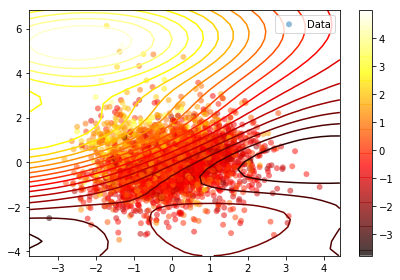

In [83]:
d = 2 # input dimension
var = 1 # variance
theta = 1 # lengthscale
k = GPy.kern.RBF(d,var,theta,ARD=True)
x = data.rna_protein[cell][['Gene Length',cell]].values
y = data.rna_protein[cell][[cell+'_P']].values
start = time.time()
m = generate_model(x,y,kernel=k.copy(),zscore=True,plot=True)
print(time.time()-start)







  0%|          | 0/9 [00:00<?, ?it/s] /gpfs/home/dshak/anaconda3/lib/python3.7/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /gpfs/home/dshak/anaconda3/lib/python3.7/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /gpfs/home/dshak/anaconda3/lib/python3.7/site-packages/matplotlib/contour.py:1000: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'






 22%|██▏       | 2/9 [00:00<00:03,  2.23it/s]

Average pearson r [0.4579639] for 125 data points


 /gpfs/home/dshak/anaconda3/lib/python3.7/site-packages/matplotlib/contour.py:1000: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'






 33%|███▎      | 3/9 [00:06<00:12,  2.13s/it]

Average pearson r [0.52061936] for 683 data points


 /gpfs/home/dshak/anaconda3/lib/python3.7/site-packages/matplotlib/contour.py:1000: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'






 44%|████▍     | 4/9 [00:50<01:12, 14.44s/it]

Average pearson r [0.49675581] for 1716 data points
Average pearson r [0.48788609] for 2882 data points


 /gpfs/home/dshak/anaconda3/lib/python3.7/site-packages/matplotlib/contour.py:1000: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'






 56%|█████▌    | 5/9 [02:54<03:09, 47.39s/it]

Average pearson r [0.49566446] for 3407 data points


 /gpfs/home/dshak/anaconda3/lib/python3.7/site-packages/matplotlib/contour.py:1000: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'






 67%|██████▋   | 6/9 [11:55<09:46, 195.45s/it]

Average pearson r [0.50009962] for 3523 data points


 /gpfs/home/dshak/anaconda3/lib/python3.7/site-packages/matplotlib/contour.py:1000: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'






 78%|███████▊  | 7/9 [32:45<17:03, 511.78s/it]

Average pearson r [0.49868957] for 3539 data points


 /gpfs/home/dshak/anaconda3/lib/python3.7/site-packages/matplotlib/contour.py:1000: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'






 89%|████████▉ | 8/9 [51:01<11:27, 687.16s/it]

Average pearson r [0.49899403] for 3541 data points


 /gpfs/home/dshak/anaconda3/lib/python3.7/site-packages/matplotlib/contour.py:1000: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'






100%|██████████| 9/9 [59:48<00:00, 639.16s/it]





 /gpfs/home/dshak/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:2366: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


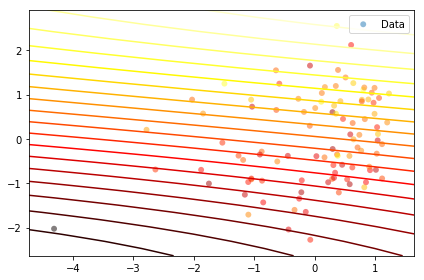

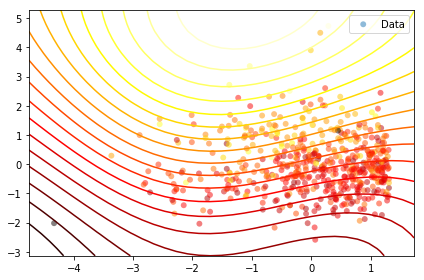

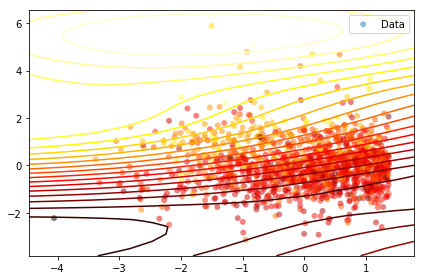

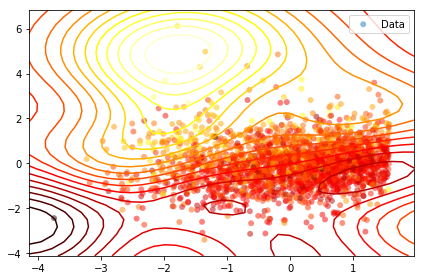

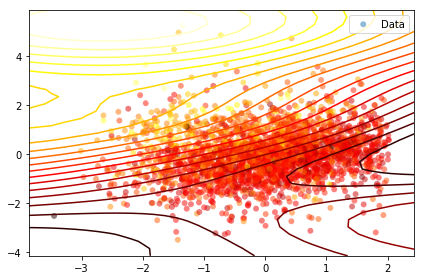

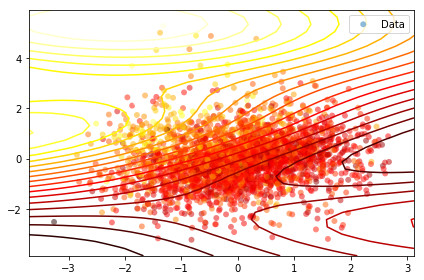

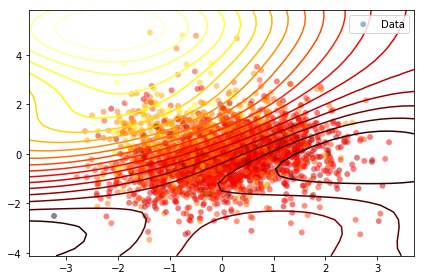

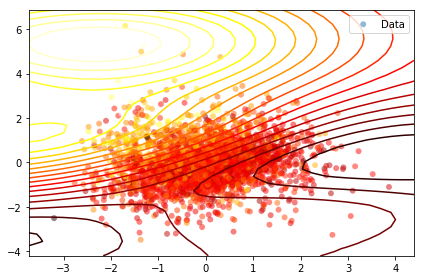

In [88]:
step=1.5
nfolds=5
max_len = np.ceil((data.rna_protein['AT2_04M_F0']['Gene Length'].values).max()).astype(int)
min_len = np.ceil((data.rna_protein['AT2_04M_F0']['Gene Length'].values).min()).astype(int)
cv_len_results = pd.DataFrame(columns=['variance','length1','length2','noise_variance','pearsonr','spearmanrho','sMSE'])

#cell_lines = ['AT2_04M_F0'
# 'AT2_04M_F10'
# 'AT2_18M_F0'
# 'AT2_18M_F10'
# 'AM_04M_F0'
# 'AM_04M_F10'
# 'AM_18M_F0'
# 'AM_18M_F10'

cell = 'AT2_04M_F0'

#Initialize base kernel to use (ARD)
d = 2 # input dimension
var = 1 # variance
theta = 1 # lengthscale
k = GPy.kern.RBF(d,var,theta,ARD=True)

for i in tqdm(np.arange(min_len,max_len+step,step)):
    #Generating cv scores for various lengths
    x = data.rna_protein[cell][['Gene Length',cell]][data.rna_protein[cell]['Gene Length']<i].values
    y = data.rna_protein[cell][[cell+'_P']][data.rna_protein[cell]['Gene Length']<i].values

    if len(x) > 30:
        models,pearsons,spearmans,sMSEs = cv_model(x,y,kernel=k.copy(),nfolds=nfolds,zscore=True)
        results = {}
        results['variance'] = np.mean([m.rbf.variance[0] for m in models])
        results['length1'] = np.mean([m.rbf.lengthscale[0] for m in models])
        results['length2'] = np.mean([m.rbf.lengthscale[1] for m in models])
        results['noise_variance'] = np.mean([m.Gaussian_noise.variance[0] for m in models])
        results['pearsonr'] = np.mean(pearsons,axis=0)
        results['spearmanrho'] = np.mean(spearmans,axis=0)
        results['sMSE'] = np.mean(sMSEs)
        row = pd.Series(results,name=f'{cell}')
        cv_len_results = cv_len_results.append(row)    
        
        print(f"Average pearson r {results['pearsonr'][0]} for {len(x)} data points")
        models[0].plot()
              
cv_len_results.to_csv(f'{cell}/genelength_cv.tsv',sep='\t')

## Using different gene lengths generated above make and store the plots

In [133]:
step=1.5
nfolds=5
max_len = np.ceil((data.rna_protein['AT2_04M_F0']['Gene Length'].values).max()).astype(int)
min_len = np.ceil((data.rna_protein['AT2_04M_F0']['Gene Length'].values).min()).astype(int)
cv_len_results = pd.DataFrame(columns=['variance','length1','length2','noise_variance','pearsonr','spearmanrho','sMSE'])

cell = 'AT2_04M_F0'

#Initialize base kernel to use (ARD)
d = 2 # input dimension
var = 1 # variance
theta = 1 # lengthscale
k = GPy.kern.RBF(d,var,theta,ARD=True)

#Uniform grid for plotting
num_points=100
xmin,xmax = -6.5,6.5
ymin,ymax = -6.5,6.5
grid_x, grid_y = np.meshgrid(np.linspace(xmin, xmax, num_points), np.linspace(ymin, ymax, num_points))
grid = np.hstack((grid_x.reshape(-1,1),grid_y.reshape(-1,1)))
norm = matplotlib.colors.Normalize(vmin=-4,vmax=4)


for i in tqdm(np.arange(min_len,max_len+step,step)):
    #Generating cv scores for various lengths
    x,_,_ = ZScore(data.rna_protein[cell][['Gene Length',cell]][data.rna_protein[cell]['Gene Length']<i].values)
    y,_,_ = ZScore(data.rna_protein[cell][[cell+'_P']][data.rna_protein[cell]['Gene Length']<i].values)

    if len(x) > 30:
        m = generate_model(x,y,kernel=k.copy(),zscore=False,plot=False)
        _ = m.plot()
        ax = plt.gca()
        ax.figure.savefig(f"{cell}/lengths/{cell}_lesslength{i}.pdf")
        plt.close()
        
        z = m.predict(grid)[0].reshape(grid_x.shape)
        fig, ax = plt.subplots()
        c = ax.pcolormesh(grid_x, grid_y, z, cmap=cm.RdBu, norm = norm)
        ax.contour(grid_x, grid_y, z,cmap=cm.RdBu) #Non normalized values, keep that in mind
        ax.scatter(x[:,0],x[:,1],c=y.squeeze(),cmap=cm.RdBu, norm = norm, alpha =0.65)
        fig.colorbar(c, ax=ax)
        fig.savefig(f"{cell}/{cell}_lesslength{i}_grid.pdf")
        plt.close()



















  0%|          | 0/9 [00:00<?, ?it/s]

















 22%|██▏       | 2/9 [00:03<00:11,  1.58s/it]

















 33%|███▎      | 3/9 [00:08<00:16,  2.71s/it]

















 44%|████▍     | 4/9 [00:30<00:41,  8.37s/it]

















 56%|█████▌    | 5/9 [01:15<01:17, 19.46s/it]

















 67%|██████▋   | 6/9 [02:16<01:35, 31.95s/it]

















 78%|███████▊  | 7/9 [03:30<01:28, 44.49s/it]

















 89%|████████▉ | 8/9 [04:33<00:50, 50.15s/it]

















100%|██████████| 9/9 [05:35<00:00, 53.57s/it]



















## Generate all models and save according plots/models

In [ ]:
# # method to save and load gpy models
# # let X, Y be data loaded above
# # Model creation:
# m = GPy.models.GPRegression(X, Y)
# m.optimize()
# # 1: Saving a model:
# np.save('model_save.npy', m.param_array)
# # 2: loading a model
# # Model creation, without initialization:
# m_load = GPy.models.GPRegression(X, Y, initialize=False)
# m_load.update_model(False) # do not call the underlying expensive algebra on load
# m_load.initialize_parameter() # Initialize the parameters (connect the parameters up)
# m_load[:] = np.load('model_save.npy') # Load the parameters
# m_load.update_model(True) # Call the algebra only once
# print(m_load)

In [192]:
cell_lines = ['AT2_04M_F0',
'AT2_04M_F10',
'AT2_18M_F0',
'AT2_18M_F10',
'AM_04M_F0',
'AM_04M_F10',
'AM_18M_F0',
'AM_18M_F10']

d = 2 # input dimension
var = 1 # variance
theta = 1 # lengthscale
k = GPy.kern.RBF(d,var,theta,ARD=True)

models = []

for cell in tqdm(cell_lines):
    x = data.rna_protein[cell][['Gene Length',cell]].values
    y = data.rna_protein[cell][[cell+'_P']].values
    m = generate_model(x,y,kernel=k.copy(),zscore=True)
    models.append(m.copy())
    _ = m.plot()
    ax = plt.gca()
    ax.figure.savefig(f"{cell}/{cell}_model.pdf")
    np.save(f"{cell}/{cell}_gpy.npy", m.param_array)
    plt.close()





















  0%|          | 0/8 [00:00<?, ?it/s]


















 12%|█▎        | 1/8 [01:03<07:25, 63.70s/it]


















 25%|██▌       | 2/8 [02:18<06:42, 67.09s/it]


















 38%|███▊      | 3/8 [03:25<05:35, 67.15s/it]


















 50%|█████     | 4/8 [04:33<04:29, 67.29s/it]


















 62%|██████▎   | 5/8 [06:02<03:41, 73.70s/it]


















 75%|███████▌  | 6/8 [07:17<02:28, 74.24s/it]


















 88%|████████▊ | 7/8 [08:45<01:18, 78.19s/it]


















100%|██████████| 8/8 [10:05<00:00, 78.93s/it]




















## Generate pcolor mesh for each model and differences, also generate predictions for mRNA with missing protein levels

In [287]:
#Uniform grid for plotting
num_points=100
xmin,xmax = -6.5,6.5
ymin,ymax = -6.5,6.5
grid_x, grid_y = np.meshgrid(np.linspace(xmin, xmax, num_points), np.linspace(ymin, ymax, num_points))
grid = np.hstack((grid_x.reshape(-1,1),grid_y.reshape(-1,1)))
norm = matplotlib.colors.Normalize(vmin=-3,vmax=3)

predictions = {}

#Grids
for m, cell in zip(models,cell_lines):
    x,x_means,x_stds = ZScore(data.rna_protein[cell][['Gene Length',cell]].values)
    y,y_means,y_stds = ZScore(data.rna_protein[cell][[cell+'_P']].values)
    
    #for unknown protein values
    x_pred = (data.rna[cell][data.rna[cell][cell+'_P']==0][['Gene Length',cell]].values-x_means)/x_stds #zscore using values from original dataset
    z_pred = m.predict(x_pred)[0]
    z_pred = z_pred*y_stds + y_means #unzscore
    
    predicted = pd.DataFrame(data=z_pred,index=data.rna[cell][data.rna[cell][cell+'_P']==0].index,columns = [cell+'_P']) #create dataframe with the predited values
    subset = data.rna[cell][data.rna[cell][cell+'_P']==0].drop(columns=cell+'_P').join(predicted) #join the new predicted values to the subset of the existing table
    subset.to_csv(f'{cell}/UnknownProteinPred.tsv',sep='\t')
    
    #For grid
    z = m.predict(grid)[0].reshape(grid_x.shape)
    fig, ax = plt.subplots()
    c = ax.pcolormesh(grid_x, grid_y, z, cmap=cm.viridis, norm = norm)
    ax.contour(grid_x, grid_y, z,cmap=cm.viridis)
    ax.scatter(x[:,0],x[:,1],c=y.squeeze(),cmap=cm.viridis, norm = norm, alpha = 0.65)
    ax.set(xlim=(-4, 4), ylim=(-4, 4))
    fig.colorbar(c, ax=ax)
    fig.savefig(f"{cell}/{cell}_grid.pdf")
    plt.close()
    
    predictions[cell] = z.copy()
        

### Difference plots

In [288]:
norm = matplotlib.colors.Normalize(vmin=-1,vmax=1)
#Difference maps
for cell in cell_lines:
    for cell2 in cell_lines:
        if cell==cell2:
            pass
        else:
            z_diff = predictions[cell]-predictions[cell2]
            fig, ax = plt.subplots()
            c = ax.pcolormesh(grid_x, grid_y, z_diff, cmap=cm.viridis, norm = norm)
            ax.set(xlim=(-4, 4), ylim=(-4, 4))
            fig.colorbar(c, ax=ax)
            fig.savefig(f"{cell}/{cell}vs{cell2}.pdf")
            plt.close()
            
            fig, ax = plt.subplots()
            c = ax.pcolormesh(grid_x, grid_y, np.abs(z_diff), cmap=cm.viridis, norm = norm)
            ax.set(xlim=(-4, 4), ylim=(-4, 4))
            fig.colorbar(c, ax=ax)
            fig.savefig(f"{cell}/abs_{cell}vs{cell2}.pdf")
            plt.close()    

In [18]:
AT2_04M_F0 = gp_data[base_cols+['AT2_04M_F0','AT2_04M_F0_P']][gp_data['AT2_04M_F0_P']!=0]


In [20]:
X = AT2_04M_F0[['AT2_04M_F0','Gene Length']]

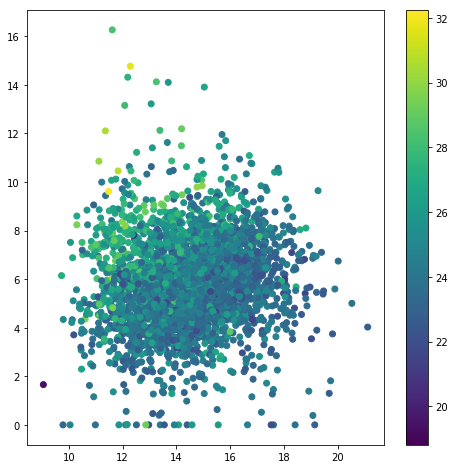

In [13]:
%matplotlib inline
fig = plt.figure()
fig.set_size_inches(8,8)
ax = fig.add_subplot(111)
AT2_04M_F0 = gp_data[base_cols+['AT2_04M_F0','AT2_04M_F0_P']][gp_data['AT2_04M_F0_P']!=0]
sc = ax.scatter(np.log2(AT2_04M_F0['Gene Length']),AT2_04M_F0['AT2_04M_F0'],c=AT2_04M_F0['AT2_04M_F0_P'],cmap = cm.viridis)
plt.colorbar(sc)

In [29]:
AT2_04M_F0.shape

(3561, 7)

In [56]:
vsp_data = pd.read_csv('../Data/vsp_input.tsv',sep='\t')
vsp_data = vsp_data[vsp_data['WSU_Old']!=17] #Removes psudovalues
vsp_data['gene length'] = np.log2(vsp_data['gene length'])
vsp_data.set_index('Gene.names',inplace=True)
vsp_data.drop(columns='Gene.description',inplace=True)

(3807, 8)
(3581, 8)


In [61]:
set(vsp_data['AvgChrs'].astype(int))

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20}

In [33]:
np.random.seed(1)

In [34]:
vsp_data = pd.read_csv('../Data/vsp_input.tsv',sep='\t')
chrm1_data = vsp_data[vsp_data['AvgChrs']<=1]
chrm1_data = chrm1_data[chrm1_data['WSU_Old']!=17]
chrm1_data['gene length'] = np.log2(chrm1_data['gene length'])
chrm1_data.set_index('Gene.names',inplace=True)
chrm1_data.drop(columns='Gene.description',inplace=True)

In [35]:
#Subset data into different partitions to test how much data the GP needs
data_percent = 0.8

msk = np.random.rand(len(chrm1_data)) < data_percent
train_chrm1 = chrm1_data[msk]
test_chrm1 = chrm1_data[~msk]

In [36]:
means = train_chrm1.mean(axis=0)
stds = train_chrm1.std(axis=0)
train_chrm1 = (train_chrm1-means)/stds
test_chrm1 = (test_chrm1-means)/stds

In [37]:
x=train_chrm1[['gene length','AT2_18M_F10']].values
y=train_chrm1[['WSU_Old']].values
x_test = test_chrm1[['gene length','AT2_18M_F10']].values
y_truth=test_chrm1[['WSU_Old']].values

 /gpfs/home/dshak/anaconda3/lib/python3.7/site-packages/matplotlib/contour.py:1000: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


 /gpfs/home/dshak/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:2366: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


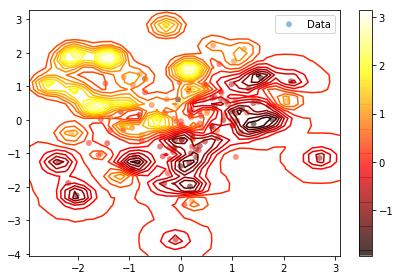

In [42]:
d = 2 # input dimension
var = 1. # variance
theta = 0.2 # lengthscale
k = GPy.kern.RBF(d,var,theta,ARD=True)
m = GPy.models.GPRegression(x,y,k)
_ = m.plot()
ax = plt.gca()
mappable=ax.collections[0]
plt.colorbar(mappable)

In [46]:
predicted = m.predict(x_test)
y_predicted = predicted[0]

pearsonr = scipy.stats.pearsonr(y_truth,y_predicted)
spearmanrho = scipy.stats.spearmanr(y_truth,y_predicted)
sMSE = mean_squared_error(y_truth,y_predicted)/np.var(y_truth)
print(f'pearson r {pearsonr}')
print(f'spearman rho {spearmanrho}')
print(f'sMSE {sMSE}, MSE {mean_squared_error(y_truth,y_predicted)}')

pearson r (array([0.41580831]), array([0.00762037]))
spearman rho SpearmanrResult(correlation=0.5527204502814259, pvalue=0.00021699858650151214)
sMSE 0.8423871656271423, MSE 1.2278393212289782


In [47]:
m.optimize(messages=1, ipython_notebook=True)

pearson r (array([0.70321495]), array([4.18914782e-07]))
spearman rho SpearmanrResult(correlation=0.6348968105065667, pvalue=1.0810302288400107e-05)
sMSE 0.6293437612472706, MSE 0.9173133781712532


 /gpfs/home/dshak/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:2366: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


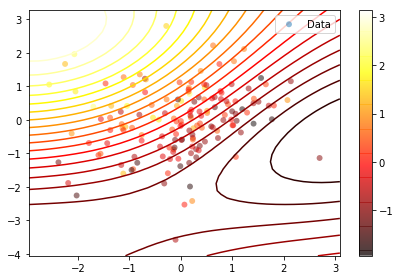

In [49]:
_ = m.plot()
ax = plt.gca()
mappable=ax.collections[0]
plt.colorbar(mappable)

predicted = m.predict(x_test)
y_predicted = predicted[0]

pearsonr = scipy.stats.pearsonr(y_truth,y_predicted)
spearmanrho = scipy.stats.spearmanr(y_truth,y_predicted)
sMSE = mean_squared_error(y_truth,y_predicted)/np.var(y_truth)

print(f'pearson r {pearsonr}')
print(f'spearman rho {spearmanrho}')
print(f'sMSE {sMSE}, MSE {mean_squared_error(y_truth,y_predicted)}')

In [54]:
m.kern.lengthscale[1]

2.9450350944264576